<a href="https://colab.research.google.com/github/iknyazeva/InverseProblem/blob/main/notebooks/model_training_example_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example

Some necessary imports:

In [1]:
!git clone https://github.com/iknyazeva/InverseProblem

Cloning into 'InverseProblem'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (275/275), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 275 (delta 179), reused 216 (delta 122), pack-reused 0
Receiving objects: 100% (275/275), 1.39 MiB | 8.99 MiB/s, done.
Resolving deltas: 100% (179/179), done.


In [2]:
cd InverseProblem

/content/InverseProblem


In [3]:
import inverse_problem

In [4]:
from inverse_problem.nn_inversion.main import HyperParams, Model
from inverse_problem import get_project_root
from inverse_problem.milne_edington.me import read_full_spectra

import json
from pprint import pprint
import os
from astropy.io import fits
import matplotlib.pyplot as plt

from google_drive_downloader import GoogleDriveDownloader as gdd
from pathlib import Path

## MLP example

All hyperparameters, model configurations are stored in json file

In [5]:
path_to_json = os.path.join(get_project_root(), 'res_experiments', 'hps_base_mlp.json')
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'batch_size': 20,
 'bottom_net': 'BottomSimpleMLPNet',
 'bottom_output': 40,
 'cont_scale': 40000,
 'factors': [1, 1000, 1000, 1000],
 'hidden_size': 40,
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'per_epoch': 10,
 'predict_ind': [0, 1, 2],
 'source': 'database',
 'top_net': 'TopNet',
 'top_output': 3,
 'transform_type': 'mlp_transform_rescale'}


Baseline model is 4 layer perceptron

In [6]:
# read parameters from file
hps = HyperParams.from_file(path_to_json=path_to_json)

# let's change batch size
hps.batch_size = 20

# and the size of training dataset
hps.per_epoch = 100

model = Model(hps)
model.net

FullModel(
  (bottom): BottomSimpleMLPNet(
    (fc1): Linear(in_features=224, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=40, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (top): TopNet(
    (fc1): Linear(in_features=41, out_features=40, bias=True)
    (fc2): Linear(in_features=40, out_features=3, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

Download training data

In [7]:
data_id = '12GslrX_J0Pw9jfr23oWoJ5gDb_I91Mj7'
gdd.download_file_from_google_drive(file_id=data_id,
                                    dest_path='data/parameters_base.fits', showsize=True)

272.7 MiB Done.


Start training!

In [ ]:
history = model.train(scheduler=True)

Or load pretrained model

In [8]:
mlp_ = '1oHeI55rT0hm-nZQ5MtciE3X-AiKCL9o6'
gdd.download_file_from_google_drive(file_id=mlp_,
                                    dest_path='/content/mlp_example.pt', showsize=True)

128.0 KiB Done.


In [9]:
path_to_load = '/content/mlp_example.pt'
model.load_model(path_to_load)

Continue trainig

In [ ]:
model.continue_training(path_to_load, scheduler=False)
# and save model
path_to_save = '/content/continue.pt'
model.save_model(path_to_save)

Inference

In [10]:
# load real data example
zip_id ='1ks6W2bgL4x_LKLg8EukX1A8GvAbvQpkm'
gdd.download_file_from_google_drive(file_id=zip_id,
                                    dest_path='data/reference.zip', showsize=True)

147.2 MiB Done.


In [11]:
!unzip -q /content/InverseProblem/data/reference.zip

In [12]:
# this code sorts loaded files in proper order
import glob
sp_path = '/content/InverseProblem/20170905_030404/'
sp_lines = sorted(glob.glob(sp_path+'*.fits'))
print(len(sp_lines))

485


In [13]:
filename = '/content/InverseProblem/20170905_030404/'
line, cont = read_full_spectra(flist=sp_lines)

100%|██████████| 485/485 [00:01<00:00, 327.17it/s]


In [ ]:
    def predict_full_image(self, x, parameter):
        """ Predicts full image
        Args:
            x (tuple): [0] array of size (n, 512), [1] continuum vector;
            parameter (int): index of parameter to predict
        """
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        line = torch.FloatTensor(x[0]).to(device)
        cont = torch.FloatTensor(x[1]).to(device)
        output = np.zeros(line.shape[:2])
        model.eval()
        with torch.no_grad():
            for i in range(line.shape[0]):
                predicted = model((line[i], cont)).cpu()
                output[i] = predicted[:, parameter]
        return output.T

In [ ]:
import torch
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

In [14]:
predicted = model.predict_full_image((line, cont), 0)

In [15]:
# load real image
ref_id ='1ylXZjKTx0riGwq520f2IuD4k_z3z5piN'
gdd.download_file_from_google_drive(file_id=ref_id,
                                    dest_path='data/ref.fits', showsize=True)

35.9 MiB Done.


In [16]:
fits_path = os.path.join(get_project_root(), 'data', 'ref.fits')
reference = fits.open(fits_path)

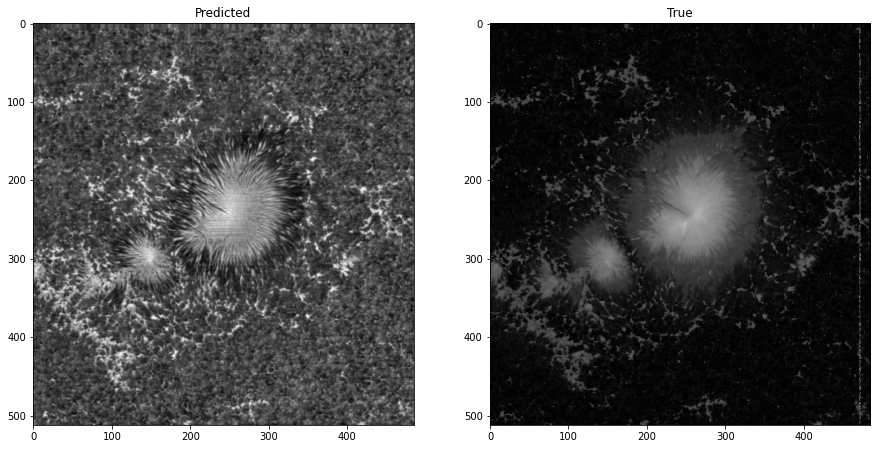

In [17]:
def plot_spectra(pred, true):
  plt.figure(figsize=(15,15))
  plt.subplot(1, 2, 1)
  plt.imshow(pred, cmap='gray')
  plt.title('Predicted')

  plt.subplot(1, 2, 2)
  plt.imshow(true, cmap='gray')
  plt.title('True')

plot_spectra(predicted, reference[1].data)

## CNN example

All the same steps

In [18]:
path_to_json = os.path.join(get_project_root(), 'res_experiments', 'hps_base_conv.json')
hps = HyperParams.from_file(path_to_json=path_to_json)
hps.batch_size = 100
hps.n_epochs = 5
hps.per_epoch = 20
model = Model(hps)
model.net

FullModel(
  (bottom): BottomSimpleConv1d(
    (conv1): Sequential(
      (0): Conv1d(4, 32, kernel_size=(2,), stride=(1,), padding=(2,))
      (1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      (2): ReLU()
      (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv1d(32, 64, kernel_size=(2,), stride=(1,))
      (1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
      (2): ReLU()
      (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (linear): Sequential(
      (0): Linear(in_features=896, out_features=40, bias=True)
      (1): ReLU()
    )
  )
  (top): TopNet(
    (fc1): Linear(in_features=41, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=3, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
  )
)

In [19]:
cnn_ = '1aITZkCU_GqbfexscISqLpyrvv8A969C2'
gdd.download_file_from_google_drive(file_id=cnn_,
                                    dest_path='/content/conv_example_5epochs.pt', showsize=True)

512.0 KiB Done.


In [20]:
# you can save model with best val loss during trainig
# or weights at particular epoch
path_to_save = '/content/conv_example_5epochs.pt'

#history = model.train(scheduler=True, save_model=True, save_epoch=[3], path_to_save=path_to_save)

In [21]:
model.load_model(path_to_save)

In [22]:
# we should change input's shape for cnn
# line.shape = (485, 512, 224)
line2 = line.reshape((485, 512, 4, 56))

In [23]:
predicted = model.predict_full_image((line2, cont), 0)

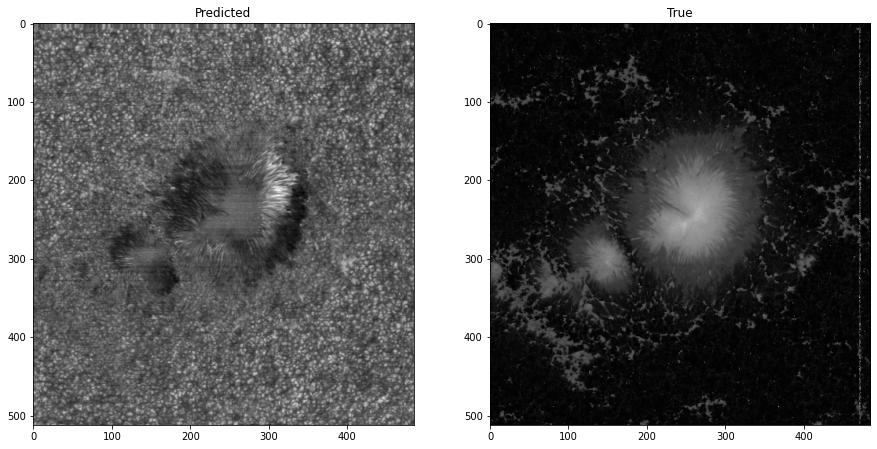

In [24]:
plot_spectra(predicted, reference[1].data)